In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_log_error

from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

1. Preparing the training data

In [3]:
train_df = gpd.read_file("train.csv")
train_df["ConfirmedCases"] = train_df["ConfirmedCases"].astype("float")
train_df["Fatalities"] = train_df["Fatalities"].astype("float")
#The country_region got modified in the enriched dataset by @optimo, 
# so we have to apply the same change to this Dataframe to facilitate the merge.
train_df["Country_Region"] = [ row.Country_Region.replace("'","").strip(" ") if row.Province_State=="" else str(row.Country_Region+"_"+row.Province_State).replace("'","").strip(" ") for idx,row in train_df.iterrows()]

In [5]:
extra_data_df = gpd.read_file("enriched.csv")
extra_data_df["Country_Region"] = [country_name.replace("'","") for country_name in extra_data_df["Country_Region"]]
extra_data_df["restrictions"] = extra_data_df["restrictions"].astype("int")
extra_data_df["quarantine"] = extra_data_df["quarantine"].astype("int")
extra_data_df["schools"] = extra_data_df["schools"].astype("int")
extra_data_df["total_pop"] = extra_data_df["total_pop"].astype("float")
extra_data_df["density"] = extra_data_df["density"].astype("float")
extra_data_df["hospibed"] = extra_data_df["hospibed"].astype("float")
extra_data_df["lung"] = extra_data_df["lung"].astype("float")
extra_data_df["total_pop"] = extra_data_df["total_pop"]/max(extra_data_df["total_pop"])
extra_data_df["density"] = extra_data_df["density"]/max(extra_data_df["density"])
extra_data_df["hospibed"] = extra_data_df["hospibed"]/max(extra_data_df["hospibed"])
extra_data_df["lung"] = extra_data_df["lung"]/max(extra_data_df["lung"])
extra_data_df["age_100+"] = extra_data_df["age_100+"].astype("float")
extra_data_df["age_100+"] = extra_data_df["age_100+"]/max(extra_data_df["age_100+"])

extra_data_df = extra_data_df[["Country_Region","Date","restrictions","quarantine","schools","hospibed","lung","total_pop","density","age_100+"]]
extra_data_df.head()

,Country_Region,Date,restrictions,quarantine,schools,hospibed,lung,total_pop,density,age_100+
0,Afghanistan,2020-01-22,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
1,Afghanistan,2020-01-23,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
2,Afghanistan,2020-01-24,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
3,Afghanistan,2020-01-25,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
4,Afghanistan,2020-01-26,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411


In [6]:
train_df = train_df.merge(extra_data_df, how="left", on=['Country_Region','Date']).drop_duplicates()
train_df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,geometry,restrictions,quarantine,schools,hospibed,lung,total_pop,density,age_100+
0,1,,Afghanistan,2020-01-22,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
1,2,,Afghanistan,2020-01-23,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
2,3,,Afghanistan,2020-01-24,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
3,4,,Afghanistan,2020-01-25,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
4,5,,Afghanistan,2020-01-26,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411


In [7]:
for country_region in train_df.Country_Region.unique():
    query_df = train_df.query("Country_Region=='"+country_region+"' and Date=='2020-03-25'")
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"total_pop"] = query_df.total_pop.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"hospibed"] = query_df.hospibed.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"density"] = query_df.density.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"lung"] = query_df.lung.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"age_100+"] = query_df["age_100+"].values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"restrictions"] = query_df.restrictions.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"quarantine"] = query_df.quarantine.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"schools"] = query_df.schools.values[0]

a. add the new countries to dataframe and fill the missing data with median values

In [8]:
median_pop = np.median(extra_data_df.total_pop)
median_hospibed = np.median(extra_data_df.hospibed)
median_density = np.median(extra_data_df.density)
median_lung = np.median(extra_data_df.lung)
median_centenarian_pop = np.median(extra_data_df["age_100+"])
#need to replace that with a joint using Pandas
print("The missing countries/region are:")
for country_region in train_df.Country_Region.unique():
    if extra_data_df.query("Country_Region=='"+country_region+"'").empty:
        print(country_region)
        
        train_df.loc[train_df["Country_Region"]==country_region,"total_pop"] = median_pop
        train_df.loc[train_df["Country_Region"]==country_region,"hospibed"] = median_hospibed
        train_df.loc[train_df["Country_Region"]==country_region,"density"] = median_density
        train_df.loc[train_df["Country_Region"]==country_region,"lung"] = median_lung
        train_df.loc[train_df["Country_Region"]==country_region,"age_100+"] = median_centenarian_pop
        train_df.loc[train_df["Country_Region"]==country_region,"restrictions"] = 0
        train_df.loc[train_df["Country_Region"]==country_region,"quarantine"] = 0
        train_df.loc[train_df["Country_Region"]==country_region,"schools"] = 0

The missing countries/region are:
Botswana
Burma
Burundi
Canada_Northwest Territories
Canada_Yukon
France_Saint Pierre and Miquelon
Kosovo
MS Zaandam
Malawi
Netherlands_Bonaire, Sint Eustatius and Saba
Sao Tome and Principe
Sierra Leone
South Sudan
United Kingdom_Anguilla
United Kingdom_British Virgin Islands
United Kingdom_Falkland Islands (Malvinas)
United Kingdom_Turks and Caicos Islands
West Bank and Gaza
Western Sahara


b. create a new dataframe which will only store 13-day trends for each location with the resulting numbers on the 14th day. The time periods extracted do not overlap on purpose.

In [9]:
trend_df = pd.DataFrame(columns={"infection_trend","fatality_trend","quarantine_trend","school_trend","total_population","expected_cases","expected_fatalities"})

In [10]:
#Just getting rid of the first days to have a multiple of 7
#Makes it easier to generate the sequences
train_df = train_df.query("Date>'2020-01-22'and Date<'2020-04-01'")
days_in_sequence = 21

trend_list = []

with tqdm(total=len(list(train_df.Country_Region.unique()))) as pbar:
    for country in train_df.Country_Region.unique():
        for province in train_df.query(f"Country_Region=='{country}'").Province_State.unique():
            province_df = train_df.query(f"Country_Region=='{country}' and Province_State=='{province}'")
            
            #I added a quick hack to double the number of sequences
            #Warning: This will later create a minor leakage from the 
            # training set into the validation set.
            for i in range(0,len(province_df),int(days_in_sequence/3)):
                if i+days_in_sequence<=len(province_df):
                    #prepare all the temporal inputs
                    infection_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].ConfirmedCases.values]
                    fatality_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].Fatalities.values]
                    restriction_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].restrictions.values]
                    quarantine_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].quarantine.values]
                    school_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].schools.values]

                    #preparing all the demographic inputs
                    total_population = float(province_df.iloc[i].total_pop)
                    density = float(province_df.iloc[i].density)
                    hospibed = float(province_df.iloc[i].hospibed)
                    lung = float(province_df.iloc[i].lung)
                    centenarian_pop = float(province_df.iloc[i]["age_100+"])

                    expected_cases = float(province_df.iloc[i+days_in_sequence-1].ConfirmedCases)
                    expected_fatalities = float(province_df.iloc[i+days_in_sequence-1].Fatalities)

                    trend_list.append({"infection_trend":infection_trend,
                                     "fatality_trend":fatality_trend,
                                     "restriction_trend":restriction_trend,
                                     "quarantine_trend":quarantine_trend,
                                     "school_trend":school_trend,
                                     "demographic_inputs":[total_population,density,hospibed,lung,centenarian_pop],
                                     "expected_cases":expected_cases,
                                     "expected_fatalities":expected_fatalities})
        pbar.update(1)
trend_df = pd.DataFrame(trend_list)

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:26<00:00, 11.65it/s]


In [11]:
trend_df["temporal_inputs"] = [np.asarray([trends["infection_trend"],trends["fatality_trend"],trends["restriction_trend"],trends["quarantine_trend"],trends["school_trend"]]) for idx,trends in trend_df.iterrows()]

trend_df = shuffle(trend_df)

In [12]:
trend_df.head()

,infection_trend,fatality_trend,restriction_trend,quarantine_trend,school_trend,demographic_inputs,expected_cases,expected_fatalities,temporal_inputs
2090,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.04716520718013237, 0.003607092683297262, 0....",2.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1841,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2322267255206195, 0.003607092683297262, 0.1...",0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
446,"[317.0, 318.0, 318.0, 318.0, 318.0, 318.0, 318...","[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.003607092683297262, 0.1956521739130435...",318.0,6.0,"[[317.0, 318.0, 318.0, 318.0, 318.0, 318.0, 31..."
1381,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.004955472930304006, 0.0006834491399931655, ...",0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
928,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.009124279218638131, 0.0020123780233132094, ...",0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


c. Only keeping 25 sequences where the number of cases stays at 0, as there were way too many of these samples in the dataset.

In [13]:
i=0
temp_df = pd.DataFrame()
for idx,row in trend_df.iterrows():
    if sum(row.infection_trend)>0:
        temp_df = temp_df.append(row)
    else:
        if i<25:
            temp_df = temp_df.append(row)
            i+=1
trend_df = temp_df

In [14]:
trend_df.head()

,demographic_inputs,expected_cases,expected_fatalities,fatality_trend,infection_trend,quarantine_trend,restriction_trend,school_trend,temporal_inputs
2090,"[0.04716520718013237, 0.003607092683297262, 0....",2.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1841,"[0.2322267255206195, 0.003607092683297262, 0.1...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
446,"[1.0, 0.003607092683297262, 0.1956521739130435...",318.0,6.0,"[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...","[317.0, 318.0, 318.0, 318.0, 318.0, 318.0, 318...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[317.0, 318.0, 318.0, 318.0, 318.0, 318.0, 31..."
1381,"[0.004955472930304006, 0.0006834491399931655, ...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
928,"[0.009124279218638131, 0.0020123780233132094, ...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


2. Splitting dataset with 90% for training and 10% for validation

In [15]:
sequence_length = 20
training_percentage = 0.9

In [16]:
training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

In [17]:
X_temporal_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in training_df["temporal_inputs"].values]),(training_item_count,5,sequence_length)),(0,2,1) )).astype(np.float32)
X_demographic_train = np.asarray([np.asarray(x) for x in training_df["demographic_inputs"]]).astype(np.float32)
Y_cases_train = np.asarray([np.asarray(x) for x in training_df["expected_cases"]]).astype(np.float32)
Y_fatalities_train = np.asarray([np.asarray(x) for x in training_df["expected_fatalities"]]).astype(np.float32)

In [18]:
X_temporal_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_df["temporal_inputs"]]),(validation_item_count,5,sequence_length)),(0,2,1)) ).astype(np.float32)
X_demographic_test = np.asarray([np.asarray(x) for x in validation_df["demographic_inputs"]]).astype(np.float32)
Y_cases_test = np.asarray([np.asarray(x) for x in validation_df["expected_cases"]]).astype(np.float32)
Y_fatalities_test = np.asarray([np.asarray(x) for x in validation_df["expected_fatalities"]]).astype(np.float32)

3. Build the model

The model is very simple in terms of architecture. The only difference from what could traditionally be seen is that it has two outputs so we can have two different losses (one for the expected number of cases and for the expected number of fatalities).

In [21]:
#temporal input branch
temporal_input_layer = Input(shape=(sequence_length,5))
main_rnn_layer = layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2)(temporal_input_layer)

#demographic input branch
demographic_input_layer = Input(shape=(5))
demographic_dense = layers.Dense(16)(demographic_input_layer)
demographic_dropout = layers.Dropout(0.2)(demographic_dense)

#cases output branch
rnn_c = layers.LSTM(32)(main_rnn_layer)
merge_c = layers.Concatenate(axis=-1)([rnn_c,demographic_dropout])
dense_c = layers.Dense(128)(merge_c)
dropout_c = layers.Dropout(0.3)(dense_c)
cases = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1),name="cases")(dropout_c)

#fatality output branch
rnn_f = layers.LSTM(32)(main_rnn_layer)
merge_f = layers.Concatenate(axis=-1)([rnn_f,demographic_dropout])
dense_f = layers.Dense(128)(merge_f)
dropout_f = layers.Dropout(0.3)(dense_f)
fatalities = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1), name="fatalities")(dropout_f)


model = Model([temporal_input_layer,demographic_input_layer], [cases,fatalities])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 5)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 20, 64)       17920       ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 16)           96          ['input_2[0][0]']                
                                                                                              

In [22]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError(),tf.keras.losses.MeanSquaredLogarithmicError()], optimizer="adam")

In [23]:
history = model.fit([X_temporal_train,X_demographic_train], [Y_cases_train, Y_fatalities_train], 
          epochs = 250, 
          batch_size = 16, 
          validation_data=([X_temporal_test,X_demographic_test],  [Y_cases_test, Y_fatalities_test]), 
          callbacks=callbacks)

Epoch 1/250
61/61 [==============================] - 9s 42ms/step - loss: 10.6234 - cases_loss: 9.3970 - fatalities_loss: 1.2264 - val_loss: 4.8751 - val_cases_loss: 3.9737 - val_fatalities_loss: 0.9013 - lr: 0.0010
Epoch 2/250
61/61 [==============================] - 2s 25ms/step - loss: 4.7366 - cases_loss: 3.8409 - fatalities_loss: 0.8956 - val_loss: 3.1364 - val_cases_loss: 2.4120 - val_fatalities_loss: 0.7244 - lr: 0.0010
Epoch 3/250
61/61 [==============================] - 1s 22ms/step - loss: 3.4454 - cases_loss: 2.7643 - fatalities_loss: 0.6811 - val_loss: 2.3320 - val_cases_loss: 1.8307 - val_fatalities_loss: 0.5013 - lr: 0.0010
Epoch 4/250
61/61 [==============================] - 1s 23ms/step - loss: 2.7344 - cases_loss: 2.2244 - fatalities_loss: 0.5100 - val_loss: 1.9867 - val_cases_loss: 1.5267 - val_fatalities_loss: 0.4600 - lr: 0.0010
Epoch 5/250
61/61 [==============================] - 1s 23ms/step - loss: 2.4216 - cases_loss: 1.9115 - fatalities_loss: 0.5102 - val_loss:

61/61 [==============================] - 2s 26ms/step - loss: 0.6085 - cases_loss: 0.4336 - fatalities_loss: 0.1749 - val_loss: 0.5044 - val_cases_loss: 0.3644 - val_fatalities_loss: 0.1400 - lr: 6.0000e-04
Epoch 39/250
61/61 [==============================] - 2s 25ms/step - loss: 0.5763 - cases_loss: 0.4261 - fatalities_loss: 0.1501 - val_loss: 0.4886 - val_cases_loss: 0.3484 - val_fatalities_loss: 0.1403 - lr: 6.0000e-04
Epoch 40/250
61/61 [==============================] - 2s 26ms/step - loss: 0.5536 - cases_loss: 0.4175 - fatalities_loss: 0.1361 - val_loss: 0.5089 - val_cases_loss: 0.3444 - val_fatalities_loss: 0.1645 - lr: 6.0000e-04
Epoch 41/250
61/61 [==============================] - 2s 27ms/step - loss: 0.5516 - cases_loss: 0.4185 - fatalities_loss: 0.1331 - val_loss: 0.4805 - val_cases_loss: 0.3501 - val_fatalities_loss: 0.1304 - lr: 6.0000e-04
Epoch 42/250
61/61 [==============================] - 2s 26ms/step - loss: 0.5482 - cases_loss: 0.4087 - fatalities_loss: 0.1395 - va

Epoch 73/250
61/61 [==============================] - 1s 24ms/step - loss: 0.4066 - cases_loss: 0.3253 - fatalities_loss: 0.0813 - val_loss: 0.3865 - val_cases_loss: 0.2789 - val_fatalities_loss: 0.1076 - lr: 1.2960e-04
Epoch 74/250
61/61 [==============================] - 1s 24ms/step - loss: 0.4057 - cases_loss: 0.3219 - fatalities_loss: 0.0839 - val_loss: 0.3805 - val_cases_loss: 0.2778 - val_fatalities_loss: 0.1027 - lr: 1.2960e-04
Epoch 75/250
61/61 [==============================] - 1s 24ms/step - loss: 0.4009 - cases_loss: 0.3237 - fatalities_loss: 0.0772 - val_loss: 0.3754 - val_cases_loss: 0.2749 - val_fatalities_loss: 0.1005 - lr: 1.2960e-04
Epoch 76/250
61/61 [==============================] - ETA: 0s - loss: 0.4027 - cases_loss: 0.3226 - fatalities_loss: 0.0801
Epoch 76: ReduceLROnPlateau reducing learning rate to 7.775999838486313e-05.
61/61 [==============================] - 1s 24ms/step - loss: 0.4027 - cases_loss: 0.3226 - fatalities_loss: 0.0801 - val_loss: 0.3779 - va

61/61 [==============================] - 1s 23ms/step - loss: 0.3734 - cases_loss: 0.3013 - fatalities_loss: 0.0721 - val_loss: 0.3499 - val_cases_loss: 0.2591 - val_fatalities_loss: 0.0908 - lr: 4.6656e-05
Epoch 109/250
61/61 [==============================] - 1s 23ms/step - loss: 0.3642 - cases_loss: 0.2940 - fatalities_loss: 0.0702 - val_loss: 0.3538 - val_cases_loss: 0.2619 - val_fatalities_loss: 0.0919 - lr: 4.6656e-05
Epoch 110/250
61/61 [==============================] - 1s 23ms/step - loss: 0.3729 - cases_loss: 0.2999 - fatalities_loss: 0.0730 - val_loss: 0.3470 - val_cases_loss: 0.2588 - val_fatalities_loss: 0.0882 - lr: 4.6656e-05
Epoch 111/250
61/61 [==============================] - 1s 24ms/step - loss: 0.3720 - cases_loss: 0.3006 - fatalities_loss: 0.0714 - val_loss: 0.3450 - val_cases_loss: 0.2559 - val_fatalities_loss: 0.0891 - lr: 4.6656e-05
Epoch 112/250
61/61 [==============================] - 1s 24ms/step - loss: 0.3714 - cases_loss: 0.3008 - fatalities_loss: 0.0706 

Epoch 142/250
61/61 [==============================] - 1s 24ms/step - loss: 0.3477 - cases_loss: 0.2820 - fatalities_loss: 0.0657 - val_loss: 0.3364 - val_cases_loss: 0.2478 - val_fatalities_loss: 0.0886 - lr: 6.0466e-06
Epoch 143/250
61/61 [==============================] - 1s 24ms/step - loss: 0.3523 - cases_loss: 0.2866 - fatalities_loss: 0.0657 - val_loss: 0.3363 - val_cases_loss: 0.2487 - val_fatalities_loss: 0.0876 - lr: 6.0466e-06
Epoch 144/250
61/61 [==============================] - ETA: 0s - loss: 0.3530 - cases_loss: 0.2862 - fatalities_loss: 0.0668
Epoch 144: ReduceLROnPlateau reducing learning rate to 3.6279706364439334e-06.
61/61 [==============================] - 1s 24ms/step - loss: 0.3530 - cases_loss: 0.2862 - fatalities_loss: 0.0668 - val_loss: 0.3371 - val_cases_loss: 0.2488 - val_fatalities_loss: 0.0883 - lr: 6.0466e-06
Epoch 145/250
61/61 [==============================] - 1s 24ms/step - loss: 0.3490 - cases_loss: 0.2846 - fatalities_loss: 0.0644 - val_loss: 0.337

4. Performance during training

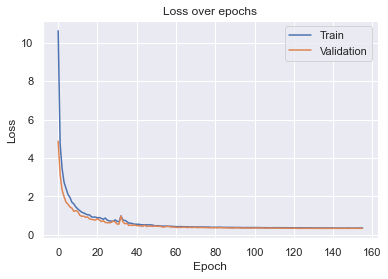

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

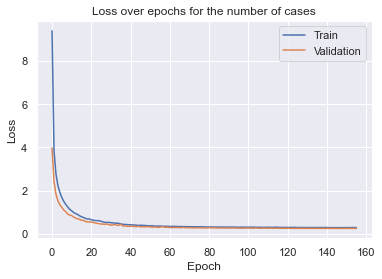

In [25]:
plt.plot(history.history['cases_loss'])
plt.plot(history.history['val_cases_loss'])
plt.title('Loss over epochs for the number of cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

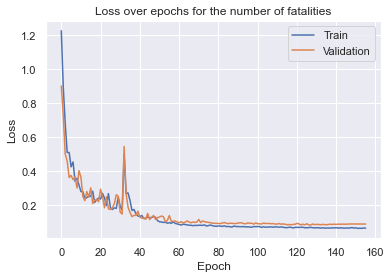

In [26]:
plt.plot(history.history['fatalities_loss'])
plt.plot(history.history['val_fatalities_loss'])
plt.title('Loss over epochs for the number of fatalities')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

5. Generate predictions using the model

In [27]:
model.load_weights("best_model.h5")

In [28]:
predictions = model.predict([X_temporal_test,X_demographic_test])

4/4 [==============================] - 1s 5ms/step


In [29]:
display_limit = 30
for inputs, pred_cases, exp_cases, pred_fatalities, exp_fatalities in zip(X_temporal_test,predictions[0][:display_limit], Y_cases_test[:display_limit], predictions[1][:display_limit], Y_fatalities_test[:display_limit]):
    print("================================================")
    print(inputs)
    print("Expected cases:", exp_cases, " Prediction:", pred_cases[0], "Expected fatalities:", exp_fatalities, " Prediction:", pred_fatalities[0] )

[[28.  0.  0.  0.  0.]
 [30.  0.  0.  0.  0.]
 [33.  0.  0.  0.  0.]
 [40.  0.  0.  0.  0.]
 [45.  0.  0.  0.  0.]
 [47.  0.  0.  0.  0.]
 [50.  0.  0.  0.  0.]
 [58.  0.  0.  0.  0.]
 [67.  0.  0.  0.  0.]
 [72.  0.  0.  0.  0.]
 [75.  0.  0.  0.  0.]
 [77.  0.  0.  0.  0.]
 [81.  0.  0.  0.  0.]
 [84.  0.  0.  0.  0.]
 [84.  0.  0.  0.  0.]
 [85.  0.  0.  0.  0.]
 [85.  0.  0.  0.  0.]
 [89.  0.  0.  0.  0.]
 [89.  0.  0.  0.  0.]
 [91.  0.  0.  0.  0.]]
Expected cases: 93.0  Prediction: 92.1766 Expected fatalities: 0.0  Prediction: -0.04036137
[[ 46.   1.   0.   0.   0.]
 [ 52.   1.   0.   0.   0.]
 [ 62.   1.   0.   0.   0.]
 [ 64.   1.   0.   0.   0.]
 [ 72.   1.   0.   0.   0.]
 [ 80.   1.   0.   0.   0.]
 [ 99.   1.   0.   0.   0.]
 [106.   1.   0.   0.   0.]
 [117.   2.   0.   0.   0.]
 [124.   2.   0.   0.   0.]
 [131.   3.   0.   0.   0.]
 [138.   3.   0.   0.   0.]
 [144.   3.   0.   0.   0.]
 [157.   4.   0.   0.   0.]
 [157.   4.   0.   0.   0.]
 [159.   4.   0.   0.   0.]

6. Apply the model to predict future trends

The following functions will be used to get the 13 previous days from a given date and demographic information, predict the number of cases and fatalities, before iterating again. Therefore, it will use the prediction for the next day as part of the data for the one afterwards.

In [31]:
def build_inputs_for_date(country, province, date, df):
    start_date = date - timedelta(days=20)
    end_date = date - timedelta(days=1)
    
    str_start_date = start_date.strftime("%Y-%m-%d")
    str_end_date = end_date.strftime("%Y-%m-%d")
    df = df.query("Country_Region=='"+country+"' and Province_State=='"+province+"' and Date>='"+str_start_date+"' and Date<='"+str_end_date+"'")
    
    #preparing the temporal inputs
    temporal_input_data = np.transpose(np.reshape(np.asarray([df["ConfirmedCases"],
                                                 df["Fatalities"],
                                                 df["restrictions"],
                                                 df["quarantine"],
                                                 df["schools"]]),
                                     (5,sequence_length)), (1,0) ).astype(np.float32)
    
    #preparing all the demographic inputs
    total_population = float(province_df.iloc[i].total_pop)
    density = float(province_df.iloc[i].density)
    hospibed = float(province_df.iloc[i].hospibed)
    lung = float(province_df.iloc[i].lung)
    centenarian_pop = float(province_df.iloc[i]["age_100+"])
    demographic_input_data = [total_population,density,hospibed,lung,centenarian_pop]
    
    return [np.array([temporal_input_data]), np.array([demographic_input_data])]

In [32]:
def predict_for_region(country, province, df):
    begin_prediction = "2020-04-01"
    start_date = datetime.strptime(begin_prediction,"%Y-%m-%d")
    end_prediction = "2020-05-14"
    end_date = datetime.strptime(end_prediction,"%Y-%m-%d")
    
    date_list = [start_date + timedelta(days=x) for x in range((end_date-start_date).days+1)]
    for date in date_list:
        input_data = build_inputs_for_date(country, province, date, df)
        result = model.predict(input_data)
        
        #just ensuring that the outputs is
        #higher than the previous counts
        result[0] = np.round(result[0])
        if result[0]<input_data[0][0][-1][0]:
            result[0]=np.array([[input_data[0][0][-1][0]]])
        
        result[1] = np.round(result[1])
        if result[1]<input_data[0][0][-1][1]:
            result[1]=np.array([[input_data[0][0][-1][1]]])
        
        #We assign the quarantine and school status
        #depending on previous values
        #e.g Once a country is locked, it will stay locked until the end
        df = df.append({"Country_Region":country, 
                        "Province_State":province, 
                        "Date":date.strftime("%Y-%m-%d"), 
                        "restrictions": 1 if any(input_data[0][0][2]) else 0,
                        "quarantine": 1 if any(input_data[0][0][3]) else 0,
                        "schools": 1 if any(input_data[0][0][4]) else 0,
                        "total_pop": input_data[1][0],
                        "density": input_data[1][0][1],
                        "hospibed": input_data[1][0][2],
                        "lung": input_data[1][0][3],
                        "age_100+": input_data[1][0][4],
                        "ConfirmedCases":round(result[0][0][0]),	
                        "Fatalities":round(result[1][0][0])},
                       ignore_index=True)
    return df

7. Check the model's performance for the beginning of April

In [35]:
groundtruth_df = gpd.read_file("train.csv")

groundtruth_df["ConfirmedCases"] = groundtruth_df["ConfirmedCases"].astype("float")
groundtruth_df["Fatalities"] = groundtruth_df["Fatalities"].astype("float")
#The country_region got modifying in the enriched dataset by @optimo, 
# so we have to apply the same change to this Dataframe.
groundtruth_df["Country_Region"] = [ row.Country_Region.replace("'","").strip(" ") if row.Province_State=="" else str(row.Country_Region+"_"+row.Province_State).replace("'","").strip(" ") for idx,row in groundtruth_df.iterrows()]

last_date = groundtruth_df.Date.unique()[-1]

In [36]:
#to remove annoying warnings from pandas
pd.options.mode.chained_assignment = None

def get_RMSLE_per_region(region, groundtruth_df, display_only=False):
    groundtruth_df["ConfirmedCases"] = groundtruth_df["ConfirmedCases"].astype("float")
    groundtruth_df["Fatalities"] = groundtruth_df["Fatalities"].astype("float")
    
    #we only take data until the 30th of March 2020 as the groundtruth was not available for later dates.
    groundtruth = groundtruth_df.query("Country_Region=='"+region+"' and Date>='2020-04-01' and Date<='"+last_date+"'")
    predictions = copy_df.query("Country_Region=='"+region+"' and Date>='2020-04-01' and Date<='"+last_date+"'")
    
    RMSLE_cases = np.sqrt(mean_squared_log_error( groundtruth.ConfirmedCases.values, predictions.ConfirmedCases.values ))
    RMSLE_fatalities = np.sqrt(mean_squared_log_error( groundtruth.Fatalities.values, predictions.Fatalities.values ))
    
    if display_only:
        print(region)
        print("RMSLE on cases:",np.mean(RMSLE_cases))
        print("RMSLE on fatalities:",np.mean(RMSLE_fatalities))
    else:
        return RMSLE_cases, RMSLE_fatalities

In [37]:
def get_RMSLE_for_all_regions(groundtruth_df):
    RMSLE_cases_list = []
    RMSLE_fatalities_list = []
    for region in groundtruth_df.Country_Region.unique():
        RMSLE_cases, RMSLE_fatalities = get_RMSLE_per_region(region, groundtruth_df, False)
        RMSLE_cases_list.append(RMSLE_cases)
        RMSLE_fatalities_list.append(RMSLE_fatalities)
    print("RMSLE on cases:",np.mean(RMSLE_cases_list))
    print("RMSLE on fatalities:",np.mean(RMSLE_fatalities_list))

We can first check whether one of the outputs is globally harder to predict than the other.

8. Outputs: Observing the curves

In [40]:
def display_comparison(region,groundtruth_df):
    groundtruth = groundtruth_df.query("Country_Region=='"+region+"' and Date>='2020-04-01' and Date<='2020-04-15'")
    prediction = copy_df.query("Country_Region=='"+region+"' and Date>='2020-04-01' and Date<='2020-04-15'")
    
    plt.plot(groundtruth.ConfirmedCases.values)
    plt.plot(prediction.ConfirmedCases.values)
    plt.title("Comparison between the actual data and our predictions for the number of cases")
    plt.ylabel('Number of cases')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()
    
    plt.plot(groundtruth.Fatalities.values)
    plt.plot(prediction.Fatalities.values)
    plt.title("Comparison between the actual data and our predictions for the number of fatalities")
    plt.ylabel('Number of fatalities')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()

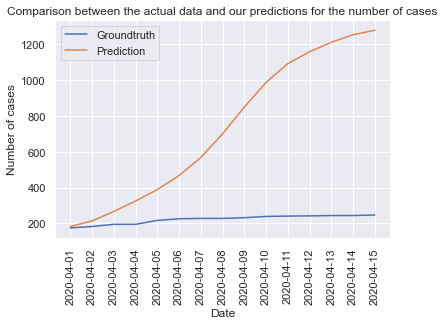

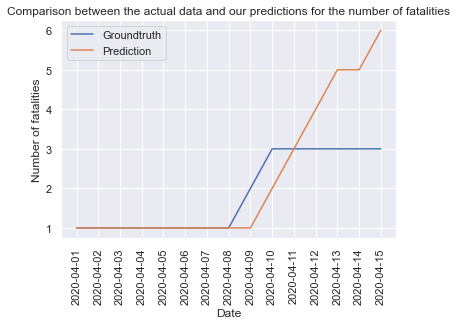

In [41]:
display_comparison("Canada_Newfoundland and Labrador", groundtruth_df)

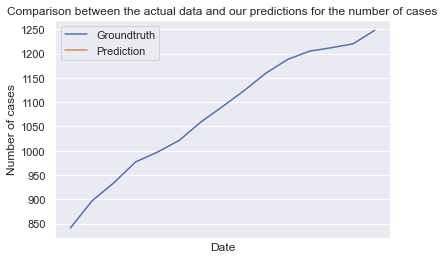

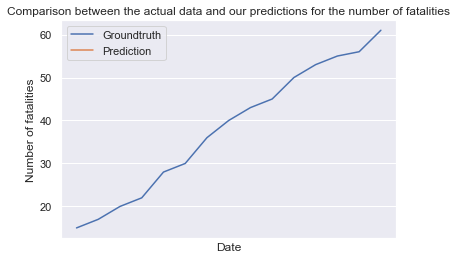

In [42]:
display_comparison("Slovenia", groundtruth_df)

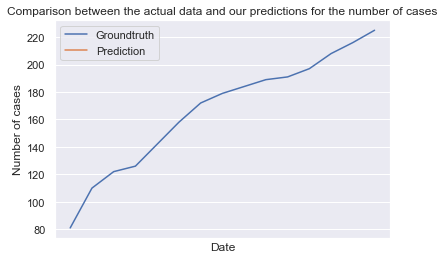

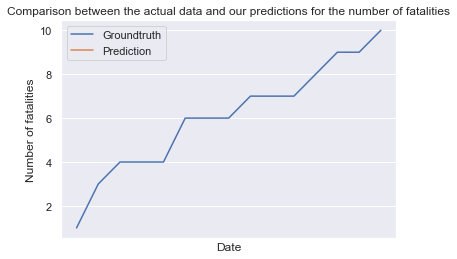

In [43]:
display_comparison("Kenya", groundtruth_df)

In [44]:
def display_long_term_prediction(region,groundtruth_df):
    groundtruth = groundtruth_df.query("Country_Region=='"+region+"' and Date>='2020-04-01' and Date<='2020-04-15'")
    prediction = copy_df.query("Country_Region=='"+region+"' and Date>='2020-04-01' and Date<='2020-05-14'")
    
    plt.plot(groundtruth.ConfirmedCases.values)
    plt.plot(prediction.ConfirmedCases.values)
    plt.title("Comparison between the actual data and our predictions for the number of cases")
    plt.ylabel('Number of cases')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()
    
    plt.plot(groundtruth.Fatalities.values)
    plt.plot(prediction.Fatalities.values)
    plt.title("Comparison between the actual data and our predictions for the number of fatalities")
    plt.ylabel('Number of fatalities')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()

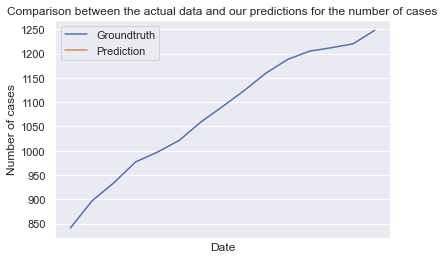

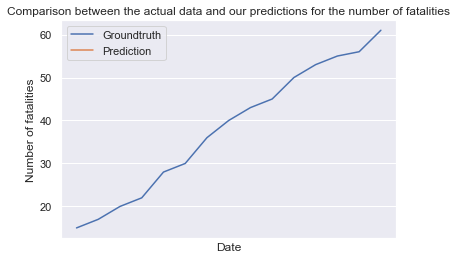

In [45]:
display_long_term_prediction("Slovenia", groundtruth_df)

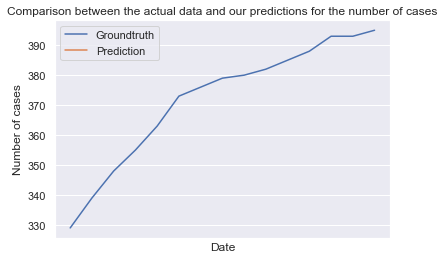

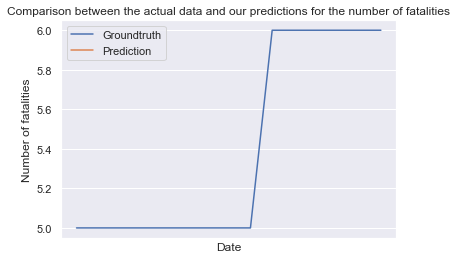

In [46]:
display_long_term_prediction("Taiwan*", groundtruth_df)

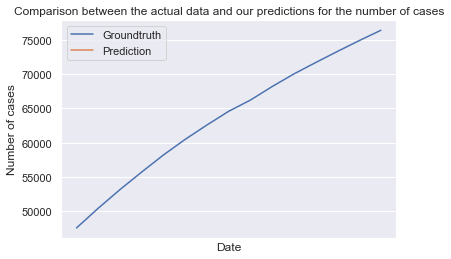

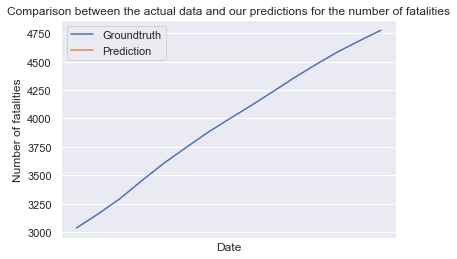

In [47]:
display_long_term_prediction("Iran", groundtruth_df)